In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9086
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #pole length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  F7UPK8AX_07_55_24
NN-MODEL FILENAME:  ./models/F7UPK8AX_07_55_24_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.725
LENGTH_ABS_MIN = 0.275

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 6
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  6


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
     # Mean values of pole length deviate from original value
    scaling_factor = 0.4 + (1.4 - 0.4) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,     LENGTH_MAX,     LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = node_q_table[:,:,:,:, int(node_id*LO_GRAIN):int((node_id+1)*LO_GRAIN)]

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES   ])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN,LO_GRAIN*NO_OF_NODES).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 71611.54 MiB, increment: 65610.51 MiB
Quantization TIME:  0.59 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   13288
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 46
TOTAL SERIAL TIMESTEPS:   13288
TOTAL PARALLEL TIMESTEPS: 46


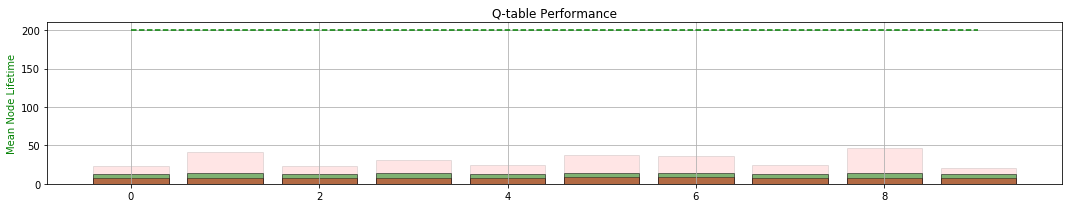

MEMORY COUNTER:  13288
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 661.186	LOSS : 596.502	LOSS : 594.262	LOSS : 582.051	LOSS : 571.825	LOSS : 579.919	LOSS : 563.356	LOSS : 560.309	LOSS : 563.911	LOSS : 540.347	LOSS : 531.706	LOSS : 530.012	LOSS : 539.439	LOSS : 526.039	LOSS : 521.265	LOSS : 514.657	LOSS : 509.780	LOSS : 507.921	LOSS : 502.039	LOSS : 497.275	
Validating... MEAN TIME:  107.685
LOSS : 491.261	LOSS : 500.498	LOSS : 502.499	LOSS : 507.724	LOSS : 478.406	LOSS : 511.513	LOSS : 487.396	LOSS : 472.139	LOSS : 501.422	LOSS : 488.257	LOSS : 471.713	LOSS : 504.170	LOSS : 477.630	LOSS : 488.952	LOSS : 473.375	LOSS : 479.947	LOSS : 486.946	LOSS : 489.230	LOSS : 479.272	LOSS : 479.875	
Validating... MEAN TIME:  125.355
LOSS : 463.721	LOSS : 478.642	LOSS : 460.757	LOSS : 483.494	LOSS : 481.432	LOSS : 450.747	LOSS : 468.806	LOSS : 462.455	LOSS : 473.966	LOSS : 465.456	LOSS : 457.346	LOSS : 470.137	LOSS : 454.185	LOSS : 468.541	LOSS : 473.456	LOSS : 475.614	LOSS : 4

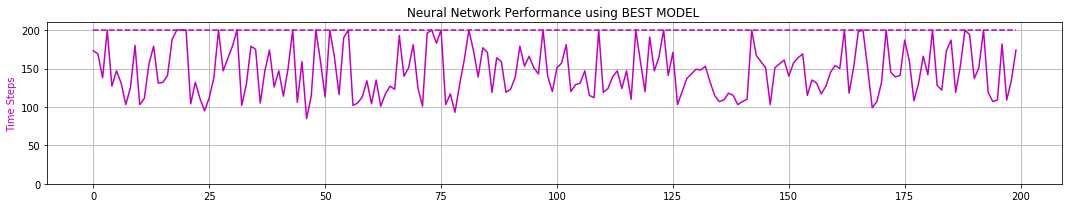

peak memory: 72462.38 MiB, increment: 65254.39 MiB
0 -max- [ 0.205  1.907  0.205  2.708  0.274]
0 -min- [-0.202 -1.774 -0.209 -2.755  0.225]

1 -max- [ 0.301  1.805  0.209  3.268  0.325]
1 -min- [-0.232 -2.673 -0.209 -2.754  0.275]

2 -max- [ 0.206  1.929  0.209  2.760  0.375]
2 -min- [-0.195 -1.780 -0.209 -2.833  0.325]

3 -max- [ 0.235  1.955  0.209  2.747  0.425]
3 -min- [-0.187 -1.711 -0.209 -2.888  0.375]

4 -max- [ 0.218  1.787  0.209  2.900  0.474]
4 -min- [-0.194 -1.971 -0.208 -2.734  0.426]

5 -max- [ 0.437  2.267  0.209  2.938  0.525]
5 -min- [-0.221 -1.962 -0.208 -2.945  0.476]

6 -max- [ 0.366  2.540  0.207  2.502  0.575]
6 -min- [-0.192 -1.598 -0.208 -2.900  0.525]

7 -max- [ 0.222  2.147  0.209  2.748  0.624]
7 -min- [-0.202 -1.806 -0.209 -2.965  0.576]

8 -max- [ 0.437  2.458  0.209  2.924  0.675]
8 -min- [-0.208 -1.921 -0.209 -2.914  0.625]

9 -max- [ 0.194  1.802  0.209  2.788  0.724]
9 -min- [-0.200 -1.792 -0.209 -2.746  0.675]

Quantization TIME:  0.58 minutes


ITER

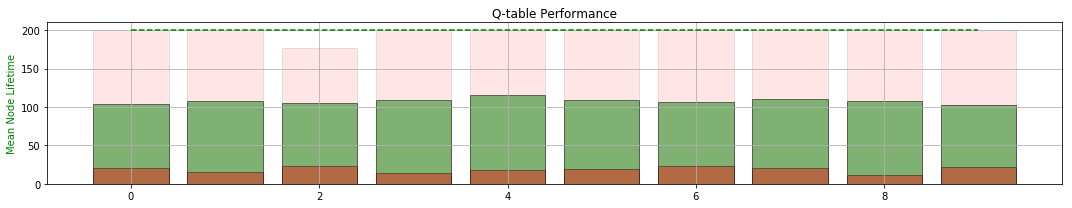

MEMORY COUNTER:  120860
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 326.845	LOSS : 330.088	LOSS : 311.129	LOSS : 274.043	LOSS : 263.313	LOSS : 250.566	LOSS : 238.679	LOSS : 226.551	LOSS : 219.152	LOSS : 215.000	LOSS : 197.515	LOSS : 192.159	LOSS : 185.918	LOSS : 185.717	LOSS : 170.160	LOSS : 192.414	LOSS : 175.445	LOSS : 176.192	LOSS : 177.708	LOSS : 182.661	
Validating... MEAN TIME:  135.33
LOSS : 174.330	LOSS : 162.330	LOSS : 170.463	LOSS : 160.652	LOSS : 158.652	LOSS : 170.329	LOSS : 160.738	LOSS : 164.579	LOSS : 166.667	LOSS : 158.684	LOSS : 155.347	LOSS : 160.948	LOSS : 158.556	LOSS : 159.800	LOSS : 162.048	LOSS : 160.367	LOSS : 165.587	LOSS : 155.348	LOSS : 162.375	LOSS : 161.166	
Validating... MEAN TIME:  150.45
LOSS : 163.546	LOSS : 158.759	LOSS : 152.115	LOSS : 161.204	LOSS : 160.087	LOSS : 168.548	LOSS : 171.834	LOSS : 157.118	LOSS : 165.102	LOSS : 160.745	LOSS : 163.114	LOSS : 155.932	LOSS : 153.006	LOSS : 161.578	LOSS : 163.903	LOSS : 159.861	LOSS : 16

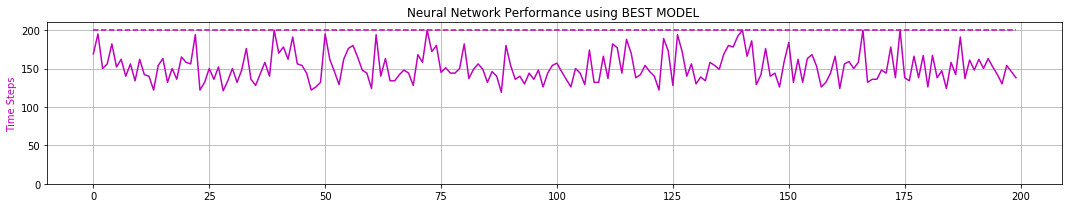

peak memory: 74038.04 MiB, increment: 65617.14 MiB
0 -max- [ 0.896  1.529  0.209  1.838  0.274]
0 -min- [-0.916 -1.904 -0.209 -2.260  0.225]

1 -max- [ 1.069  1.929  0.208  2.260  0.325]
1 -min- [-0.841 -1.827 -0.209 -2.234  0.275]

2 -max- [ 0.896  1.954  0.209  1.734  0.374]
2 -min- [-0.959 -1.876 -0.209 -1.917  0.325]

3 -max- [ 1.039  1.823  0.209  1.843  0.425]
3 -min- [-1.170 -2.024 -0.209 -2.081  0.375]

4 -max- [ 0.837  1.712  0.209  1.920  0.475]
4 -min- [-1.397 -2.258 -0.209 -2.065  0.426]

5 -max- [ 1.141  2.243  0.208  1.685  0.525]
5 -min- [-0.947 -1.849 -0.209 -1.899  0.475]

6 -max- [ 0.792  1.448  0.209  1.588  0.575]
6 -min- [-1.005 -1.876 -0.209 -2.334  0.525]

7 -max- [ 0.939  1.678  0.209  2.042  0.624]
7 -min- [-1.101 -2.050 -0.209 -1.918  0.575]

8 -max- [ 0.943  1.551  0.209  2.116  0.674]
8 -min- [-1.280 -2.204 -0.209 -2.157  0.625]

9 -max- [ 0.921  1.715  0.209  2.184  0.725]
9 -min- [-0.867 -1.875 -0.209 -2.217  0.675]

Quantization TIME:  0.59 minutes


ITER

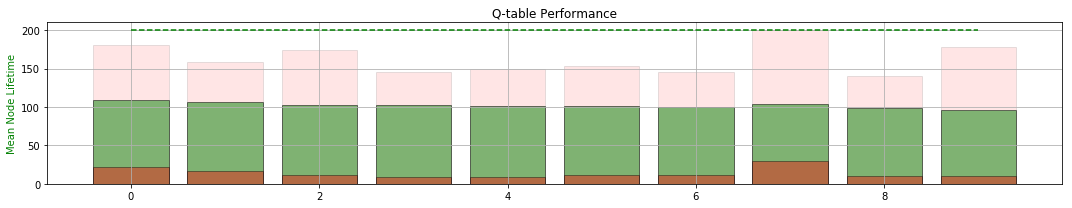

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 103.908	LOSS : 97.954	LOSS : 97.673	LOSS : 88.609	LOSS : 92.778	LOSS : 98.422	LOSS : 91.448	LOSS : 100.451	LOSS : 89.752	LOSS : 92.917	LOSS : 82.561	LOSS : 89.374	LOSS : 90.167	LOSS : 88.107	LOSS : 91.543	LOSS : 86.126	LOSS : 82.740	LOSS : 93.457	LOSS : 93.971	LOSS : 93.575	
Validating... MEAN TIME:  171.235
LOSS : 90.759	LOSS : 86.407	LOSS : 89.894	LOSS : 91.237	LOSS : 85.853	LOSS : 94.503	LOSS : 93.632	LOSS : 87.591	LOSS : 91.929	LOSS : 90.455	LOSS : 101.242	LOSS : 87.845	LOSS : 88.072	LOSS : 92.574	LOSS : 98.312	LOSS : 92.688	LOSS : 94.970	LOSS : 94.915	LOSS : 92.850	LOSS : 88.401	
Validating... MEAN TIME:  127.115
LOSS : 94.451	LOSS : 88.322	LOSS : 95.641	LOSS : 88.430	LOSS : 89.877	LOSS : 94.146	LOSS : 101.241	LOSS : 92.497	LOSS : 93.425	LOSS : 91.307	LOSS : 87.441	LOSS : 95.522	LOSS : 89.113	LOSS : 92.460	LOSS : 95.991	LOSS : 85.888	LOSS : 92.326	LOSS : 95.803	LOSS : 92.951	LOSS : 83.738	
Va

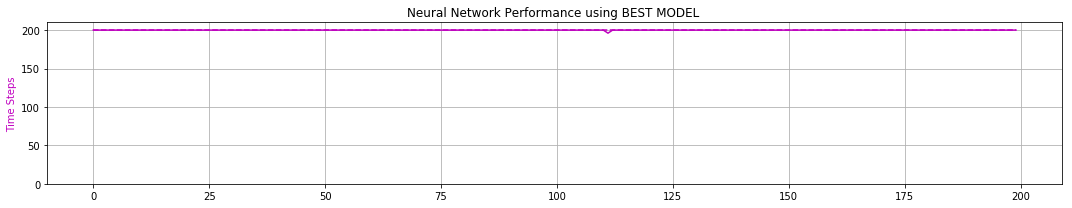

peak memory: 74058.38 MiB, increment: 65611.75 MiB
0 -max- [ 0.201  1.339  0.195  1.922  0.275]
0 -min- [-2.033 -2.590 -0.209 -1.999  0.225]

1 -max- [ 0.126  0.993  0.095  1.552  0.325]
1 -min- [-1.784 -2.381 -0.209 -1.809  0.275]

2 -max- [ 0.170  1.168  0.089  1.331  0.375]
2 -min- [-1.700 -2.245 -0.209 -1.990  0.326]

3 -max- [ 0.186  1.185  0.148  1.621  0.424]
3 -min- [-1.787 -2.226 -0.209 -1.826  0.375]

4 -max- [ 0.170  1.392  0.182  1.858  0.475]
4 -min- [-1.579 -2.210 -0.209 -1.842  0.426]

5 -max- [ 0.178  1.140  0.099  1.685  0.524]
5 -min- [-1.619 -2.189 -0.209 -1.753  0.475]

6 -max- [ 0.171  0.990  0.203  1.604  0.575]
6 -min- [-1.627 -2.209 -0.209 -1.632  0.526]

7 -max- [ 0.160  1.420  0.185  1.648  0.625]
7 -min- [-1.559 -2.195 -0.209 -2.479  0.575]

8 -max- [ 0.150  1.360  0.155  1.514  0.675]
8 -min- [-1.676 -2.592 -0.209 -2.157  0.625]

9 -max- [ 0.157  1.393  0.178  1.724  0.725]
9 -min- [-1.478 -2.421 -0.209 -2.269  0.675]

Quantization TIME:  0.59 minutes


ITER

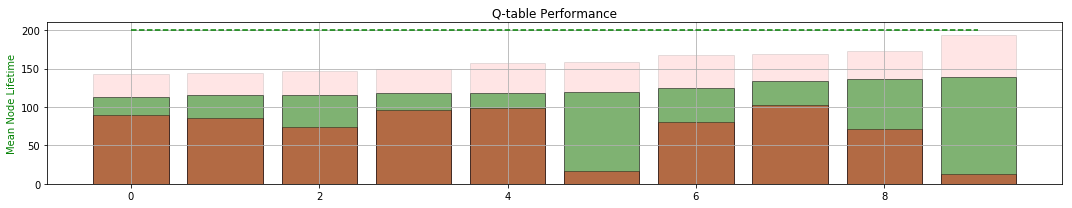

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 95.626	LOSS : 82.237	LOSS : 72.088	LOSS : 80.960	LOSS : 78.564	LOSS : 75.749	LOSS : 81.333	LOSS : 78.578	LOSS : 81.639	LOSS : 86.395	LOSS : 88.014	LOSS : 76.137	LOSS : 78.114	LOSS : 83.292	LOSS : 79.914	LOSS : 81.960	LOSS : 80.544	LOSS : 77.675	LOSS : 76.862	LOSS : 73.839	
Validating... MEAN TIME:  181.01
LOSS : 77.933	LOSS : 68.581	LOSS : 76.151	LOSS : 71.751	LOSS : 71.022	LOSS : 73.184	LOSS : 75.105	LOSS : 73.519	LOSS : 75.528	LOSS : 75.771	LOSS : 76.707	LOSS : 75.773	LOSS : 74.603	LOSS : 82.665	LOSS : 82.956	LOSS : 74.069	LOSS : 71.120	LOSS : 76.989	LOSS : 77.421	LOSS : 69.143	
Validating... MEAN TIME:  140.85
LOSS : 69.214	LOSS : 75.462	LOSS : 79.347	LOSS : 65.369	LOSS : 71.155	LOSS : 77.502	LOSS : 76.530	LOSS : 77.667	LOSS : 75.210	LOSS : 75.904	LOSS : 74.933	LOSS : 72.488	LOSS : 79.739	LOSS : 72.621	LOSS : 76.135	LOSS : 75.120	LOSS : 67.666	LOSS : 76.893	LOSS : 76.981	LOSS : 75.599	
Validati

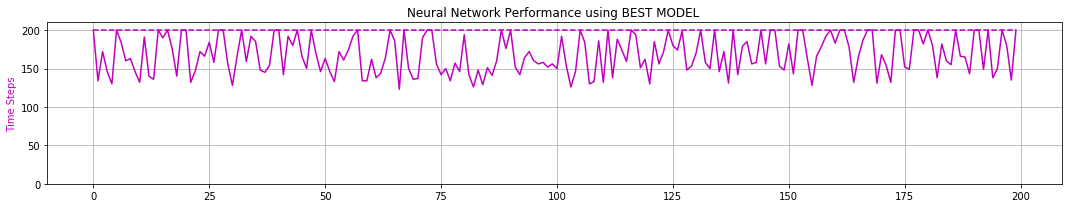

peak memory: 73839.02 MiB, increment: 65375.01 MiB
0 -max- [ 0.161  0.977  0.077  1.399  0.274]
0 -min- [-1.494 -2.203 -0.209 -1.377  0.226]

1 -max- [ 0.180  0.639  0.079  1.327  0.325]
1 -min- [-1.459 -2.059 -0.209 -1.338  0.275]

2 -max- [ 0.164  1.008  0.082  1.465  0.375]
2 -min- [-1.451 -2.062 -0.209 -1.374  0.326]

3 -max- [ 0.160  0.640  0.089  1.631  0.425]
3 -min- [-1.442 -1.991 -0.209 -1.353  0.375]

4 -max- [ 0.182  0.831  0.096  1.823  0.475]
4 -min- [-1.404 -2.020 -0.209 -1.391  0.426]

5 -max- [ 0.185  1.130  0.115  1.714  0.524]
5 -min- [-1.327 -1.860 -0.209 -1.641  0.475]

6 -max- [ 0.163  1.014  0.167  1.822  0.575]
6 -min- [-1.311 -1.817 -0.209 -1.427  0.526]

7 -max- [ 0.148  0.833  0.121  1.821  0.625]
7 -min- [-1.243 -1.728 -0.209 -1.336  0.575]

8 -max- [ 0.142  1.015  0.147  1.877  0.673]
8 -min- [-1.211 -1.738 -0.209 -1.378  0.626]

9 -max- [ 0.156  1.002  0.186  2.035  0.725]
9 -min- [-1.109 -1.911 -0.209 -1.381  0.675]

Quantization TIME:  0.58 minutes


ITER

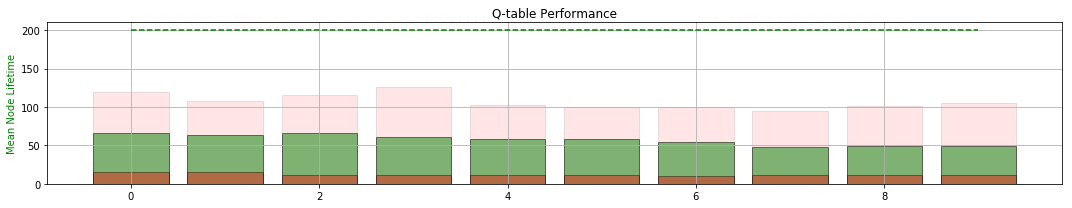

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 92.246	LOSS : 90.716	LOSS : 107.208	LOSS : 94.008	LOSS : 94.951	LOSS : 97.283	LOSS : 93.258	LOSS : 105.270	LOSS : 100.006	LOSS : 104.204	LOSS : 91.285	LOSS : 111.221	LOSS : 91.372	LOSS : 104.797	LOSS : 98.994	LOSS : 93.647	LOSS : 94.777	LOSS : 92.775	LOSS : 101.094	LOSS : 109.865	
Validating... MEAN TIME:  115.53
LOSS : 95.056	LOSS : 92.881	LOSS : 87.587	LOSS : 91.319	LOSS : 94.256	LOSS : 95.921	LOSS : 99.150	LOSS : 92.384	LOSS : 103.408	LOSS : 99.954	LOSS : 90.610	LOSS : 91.404	LOSS : 87.182	LOSS : 92.131	LOSS : 92.357	LOSS : 100.961	LOSS : 91.187	LOSS : 90.942	LOSS : 89.462	LOSS : 100.075	
Validating... MEAN TIME:  121.15
LOSS : 101.730	LOSS : 94.962	LOSS : 107.133	LOSS : 101.295	LOSS : 101.363	LOSS : 101.380	LOSS : 98.312	LOSS : 95.417	LOSS : 92.406	LOSS : 105.678	LOSS : 97.005	LOSS : 93.977	LOSS : 101.732	LOSS : 98.165	LOSS : 90.343	LOSS : 104.970	LOSS : 93.981	LOSS : 92.659	LOSS : 94.955	LOSS

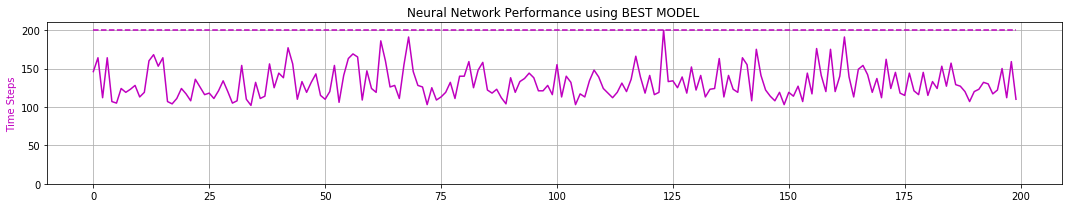

peak memory: 73541.36 MiB, increment: 65097.84 MiB
0 -max- [ 0.196  1.148  0.115  1.860  0.273]
0 -min- [-1.841 -2.396 -0.209 -1.654  0.225]

1 -max- [ 0.180  0.844  0.122  1.848  0.325]
1 -min- [-1.825 -2.394 -0.209 -1.671  0.275]

2 -max- [ 0.163  1.210  0.103  1.920  0.375]
2 -min- [-1.746 -2.394 -0.209 -1.781  0.325]

3 -max- [ 0.202  1.011  0.140  1.889  0.425]
3 -min- [-1.755 -2.413 -0.209 -1.692  0.375]

4 -max- [ 0.204  1.130  0.192  1.966  0.474]
4 -min- [-1.373 -2.100 -0.209 -1.972  0.425]

5 -max- [ 0.184  1.535  0.191  1.953  0.524]
5 -min- [-1.612 -2.156 -0.209 -2.066  0.476]

6 -max- [ 0.180  1.022  0.143  1.953  0.575]
6 -min- [-1.526 -2.146 -0.209 -1.901  0.525]

7 -max- [ 0.181  1.029  0.159  1.942  0.624]
7 -min- [-1.206 -2.102 -0.209 -1.688  0.575]

8 -max- [ 0.208  1.022  0.139  1.951  0.675]
8 -min- [-1.231 -2.124 -0.209 -1.950  0.625]

9 -max- [ 0.210  1.131  0.178  2.023  0.723]
9 -min- [-1.248 -2.106 -0.209 -1.703  0.675]

Quantization TIME:  0.59 minutes


ITER

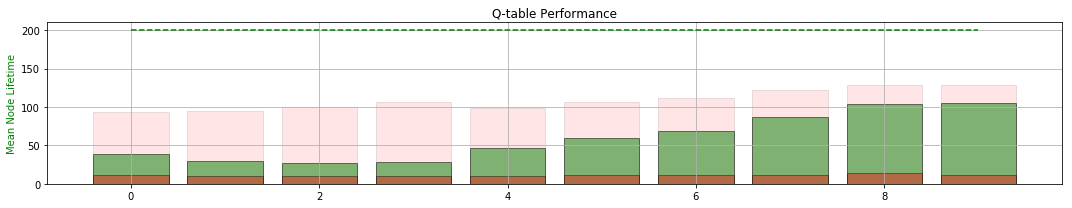

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 143.456	LOSS : 155.991	LOSS : 137.786	LOSS : 138.264	LOSS : 128.901	LOSS : 121.086	LOSS : 125.987	LOSS : 118.599	LOSS : 124.571	LOSS : 121.496	LOSS : 124.488	LOSS : 123.918	LOSS : 106.376	LOSS : 124.163	LOSS : 128.909	LOSS : 115.853	LOSS : 113.534	LOSS : 120.102	LOSS : 131.801	LOSS : 107.237	
Validating... MEAN TIME:  116.135
LOSS : 110.990	LOSS : 126.459	LOSS : 127.942	LOSS : 108.861	LOSS : 128.207	LOSS : 118.393	LOSS : 124.715	LOSS : 127.788	LOSS : 121.985	LOSS : 119.325	LOSS : 121.610	LOSS : 117.118	LOSS : 114.162	LOSS : 120.672	LOSS : 125.796	LOSS : 112.923	LOSS : 124.560	LOSS : 113.456	LOSS : 119.346	LOSS : 109.521	
Validating... MEAN TIME:  126.185
LOSS : 118.576	LOSS : 127.187	LOSS : 115.384	LOSS : 125.996	LOSS : 121.524	LOSS : 119.261	LOSS : 117.409	LOSS : 123.173	LOSS : 117.735	LOSS : 128.622	LOSS : 121.570	LOSS : 126.496	LOSS : 125.899	LOSS : 117.358	LOSS : 121.366	LOSS : 129.581	LOSS : 

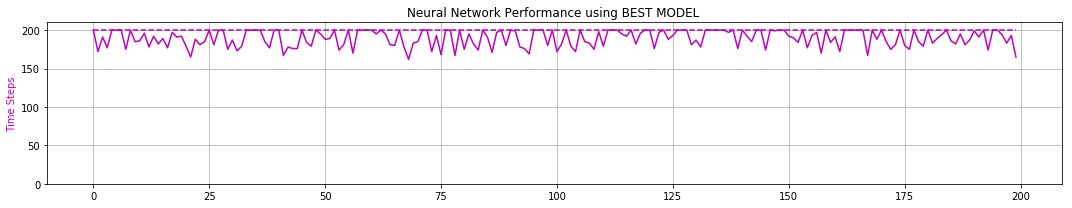

peak memory: 73437.62 MiB, increment: 64970.93 MiB
0 -max- [ 0.182  1.180  0.050  0.841  0.275]
0 -min- [-2.170 -2.897 -0.209 -1.685  0.225]

1 -max- [ 0.192  1.398  0.050  1.224  0.325]
1 -min- [-2.232 -2.958 -0.209 -1.954  0.275]

2 -max- [ 0.218  1.021  0.048  0.945  0.375]
2 -min- [-2.026 -2.759 -0.209 -1.625  0.326]

3 -max- [ 0.207  1.198  0.055  0.929  0.425]
3 -min- [-2.171 -2.618 -0.209 -1.733  0.375]

4 -max- [ 0.199  0.981  0.049  1.104  0.474]
4 -min- [-1.985 -2.601 -0.209 -1.516  0.426]

5 -max- [ 0.196  1.011  0.049  0.985  0.524]
5 -min- [-2.142 -2.720 -0.209 -1.581  0.475]

6 -max- [ 0.202  0.838  0.050  1.238  0.574]
6 -min- [-2.026 -2.515 -0.209 -1.354  0.525]

7 -max- [ 0.208  0.837  0.049  1.126  0.625]
7 -min- [-2.088 -2.534 -0.209 -1.398  0.576]

8 -max- [ 0.199  0.639  0.060  1.210  0.675]
8 -min- [-2.171 -2.604 -0.209 -1.337  0.625]

9 -max- [ 0.184  0.799  0.062  1.190  0.725]
9 -min- [-2.160 -2.516 -0.209 -1.198  0.675]

Quantization TIME:  0.59 minutes


ITER

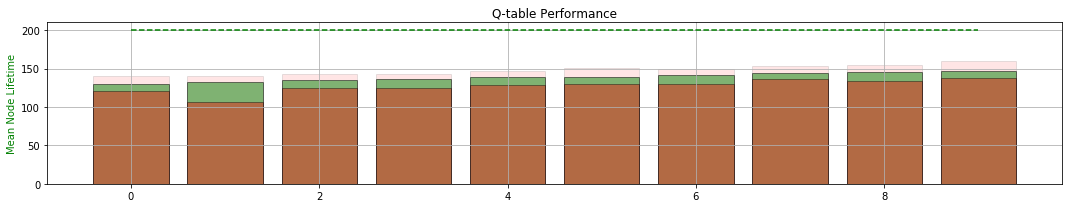

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 179.535	LOSS : 124.306	LOSS : 113.353	LOSS : 112.195	LOSS : 112.573	LOSS : 100.630	LOSS : 104.491	LOSS : 88.421	LOSS : 105.317	LOSS : 104.021	LOSS : 106.833	LOSS : 108.148	LOSS : 101.879	LOSS : 103.977	LOSS : 86.818	LOSS : 98.202	LOSS : 102.595	LOSS : 103.828	LOSS : 103.934	LOSS : 97.729	
Validating... MEAN TIME:  157.13
LOSS : 92.618	LOSS : 106.067	LOSS : 102.031	LOSS : 95.789	LOSS : 105.165	LOSS : 103.070	LOSS : 105.127	LOSS : 105.053	LOSS : 96.849	LOSS : 102.831	LOSS : 116.540	LOSS : 103.245	LOSS : 93.754	LOSS : 101.789	LOSS : 91.249	LOSS : 103.707	LOSS : 92.173	LOSS : 85.741	LOSS : 91.849	LOSS : 100.148	
Validating... MEAN TIME:  125.435
LOSS : 100.124	LOSS : 95.497	LOSS : 97.733	LOSS : 96.058	LOSS : 95.387	LOSS : 100.586	LOSS : 100.631	LOSS : 92.865	LOSS : 96.574	LOSS : 95.154	LOSS : 107.090	LOSS : 106.453	LOSS : 104.403	LOSS : 96.986	LOSS : 96.061	LOSS : 94.317	LOSS : 87.808	LOSS : 99.139	LO

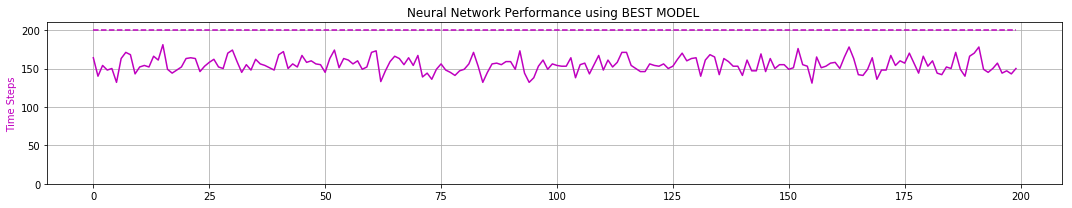

peak memory: 73785.53 MiB, increment: 65284.89 MiB
0 -max- [ 0.195  1.213  0.050  0.899  0.275]
0 -min- [-2.400 -2.611 -0.208 -1.702  0.225]

1 -max- [ 0.174  0.995  0.048  0.962  0.325]
1 -min- [-2.400 -2.610 -0.206 -1.392  0.275]

2 -max- [ 0.165  0.981  0.050  0.879  0.375]
2 -min- [-2.400 -2.570 -0.208 -1.376  0.327]

3 -max- [ 0.156  1.142  0.049  0.702  0.425]
3 -min- [-2.398 -2.579 -0.204 -1.696  0.376]

4 -max- [ 0.159  0.825  0.049  0.878  0.475]
4 -min- [-2.399 -2.539 -0.196 -1.241  0.426]

5 -max- [ 0.161  1.178  0.050  1.027  0.525]
5 -min- [-2.400 -2.434 -0.200 -1.711  0.477]

6 -max- [ 0.186  1.128  0.049  0.807  0.575]
6 -min- [-2.400 -2.419 -0.203 -1.751  0.526]

7 -max- [ 0.173  1.016  0.050  0.938  0.625]
7 -min- [-2.399 -2.394 -0.183 -1.374  0.576]

8 -max- [ 0.165  0.990  0.049  0.943  0.675]
8 -min- [-2.400 -2.368 -0.171 -1.361  0.625]

9 -max- [ 0.155  0.989  0.075  0.783  0.725]
9 -min- [-2.400 -2.366 -0.168 -1.380  0.675]

Quantization TIME:  0.59 minutes


ITER

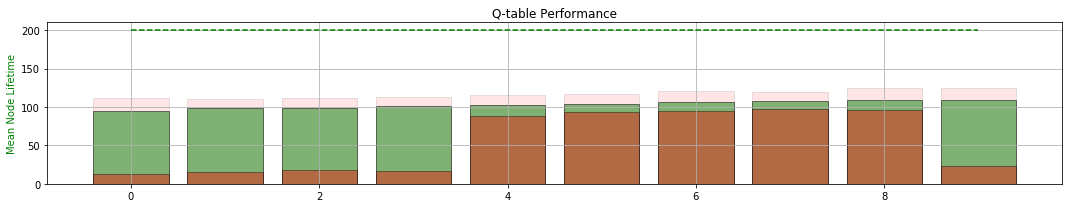

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 65.702	LOSS : 65.702	LOSS : 70.045	LOSS : 67.567	LOSS : 68.976	LOSS : 61.318	LOSS : 72.207	LOSS : 56.840	LOSS : 71.902	LOSS : 60.607	LOSS : 69.460	LOSS : 68.615	LOSS : 63.946	LOSS : 72.579	LOSS : 71.909	LOSS : 73.311	LOSS : 62.962	LOSS : 80.782	LOSS : 67.514	LOSS : 73.386	
Validating... MEAN TIME:  134.645
LOSS : 71.669	LOSS : 68.824	LOSS : 69.639	LOSS : 68.248	LOSS : 67.317	LOSS : 70.047	LOSS : 65.584	LOSS : 70.653	LOSS : 69.689	LOSS : 69.099	LOSS : 71.401	LOSS : 71.218	LOSS : 70.692	LOSS : 68.828	LOSS : 69.856	LOSS : 61.530	LOSS : 62.978	LOSS : 73.932	LOSS : 73.172	LOSS : 72.790	
Validating... MEAN TIME:  157.765
LOSS : 74.224	LOSS : 70.976	LOSS : 75.087	LOSS : 67.871	LOSS : 59.323	LOSS : 75.320	LOSS : 75.830	LOSS : 72.644	LOSS : 68.795	LOSS : 65.196	LOSS : 78.170	LOSS : 64.924	LOSS : 69.303	LOSS : 72.045	LOSS : 71.785	LOSS : 69.998	LOSS : 72.533	LOSS : 74.654	LOSS : 71.644	LOSS : 67.586	
Valida

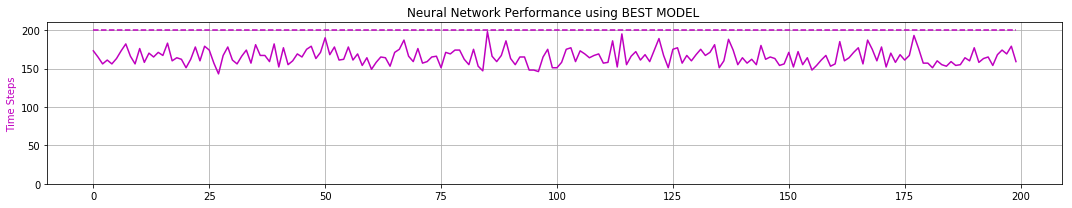

peak memory: 74067.23 MiB, increment: 65616.96 MiB
0 -max- [ 0.199  0.826  0.048  1.176  0.275]
0 -min- [-1.664 -1.987 -0.209 -1.341  0.225]

1 -max- [ 0.188  0.993  0.050  0.941  0.324]
1 -min- [-1.749 -2.043 -0.209 -1.540  0.277]

2 -max- [ 0.176  0.829  0.049  0.958  0.375]
2 -min- [-1.776 -2.166 -0.209 -1.376  0.326]

3 -max- [ 0.172  0.808  0.049  0.858  0.425]
3 -min- [-1.902 -2.219 -0.209 -1.241  0.375]

4 -max- [ 0.183  0.802  0.050  0.905  0.475]
4 -min- [-1.881 -2.159 -0.209 -1.252  0.425]

5 -max- [ 0.198  0.809  0.049  0.907  0.524]
5 -min- [-1.924 -2.208 -0.209 -1.186  0.476]

6 -max- [ 0.194  0.822  0.050  0.887  0.575]
6 -min- [-1.958 -2.048 -0.209 -1.162  0.525]

7 -max- [ 0.192  0.990  0.049  0.900  0.624]
7 -min- [-2.102 -2.231 -0.209 -1.361  0.576]

8 -max- [ 0.178  0.830  0.050  0.915  0.674]
8 -min- [-2.106 -2.207 -0.209 -1.230  0.626]

9 -max- [ 0.163  0.765  0.049  0.972  0.723]
9 -min- [-2.193 -2.392 -0.209 -1.097  0.676]

Quantization TIME:  0.59 minutes


ITER

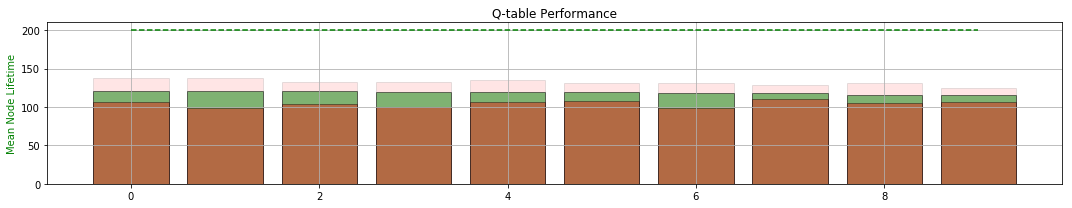

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 91.407	LOSS : 92.520	LOSS : 101.782	LOSS : 99.342	LOSS : 93.734	LOSS : 109.629	LOSS : 103.239	LOSS : 100.394	LOSS : 101.529	LOSS : 104.181	LOSS : 102.370	LOSS : 101.257	LOSS : 92.668	LOSS : 98.410	LOSS : 111.232	LOSS : 96.480	LOSS : 106.213	LOSS : 103.722	LOSS : 98.639	LOSS : 84.214	
Validating... MEAN TIME:  106.145
LOSS : 99.964	LOSS : 85.549	LOSS : 87.466	LOSS : 102.844	LOSS : 109.936	LOSS : 96.919	LOSS : 110.603	LOSS : 118.764	LOSS : 95.825	LOSS : 110.675	LOSS : 102.183	LOSS : 110.172	LOSS : 113.178	LOSS : 101.354	LOSS : 104.969	LOSS : 106.031	LOSS : 108.324	LOSS : 100.815	LOSS : 98.512	LOSS : 122.901	
Validating... MEAN TIME:  109.075
LOSS : 104.811	LOSS : 107.368	LOSS : 98.072	LOSS : 103.784	LOSS : 110.738	LOSS : 97.717	LOSS : 105.474	LOSS : 106.056	LOSS : 104.120	LOSS : 108.305	LOSS : 108.177	LOSS : 111.702	LOSS : 100.966	LOSS : 99.104	LOSS : 98.378	LOSS : 103.765	LOSS : 101.156	LOSS : 111.

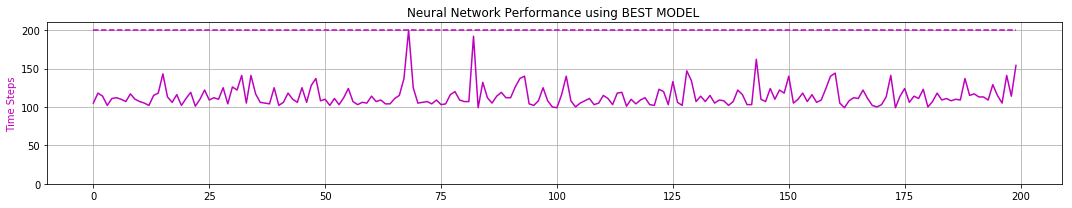

peak memory: 73808.79 MiB, increment: 65317.22 MiB
0 -max- [ 0.166  0.740  0.050  0.670  0.274]
0 -min- [-2.400 -2.739 -0.209 -1.064  0.226]

1 -max- [ 0.144  0.784  0.049  0.992  0.324]
1 -min- [-2.398 -2.743 -0.209 -1.270  0.276]

2 -max- [ 0.156  0.816  0.049  0.876  0.375]
2 -min- [-2.397 -2.777 -0.209 -1.199  0.325]

3 -max- [ 0.158  0.789  0.050  0.694  0.425]
3 -min- [-2.399 -2.761 -0.209 -1.111  0.376]

4 -max- [ 0.168  0.817  0.049  0.899  0.475]
4 -min- [-2.400 -2.766 -0.209 -1.177  0.426]

5 -max- [ 0.179  1.014  0.050  0.854  0.524]
5 -min- [-2.400 -2.607 -0.209 -1.359  0.475]

6 -max- [ 0.175  0.990  0.049  0.921  0.574]
6 -min- [-2.399 -2.605 -0.209 -1.361  0.525]

7 -max- [ 0.159  0.808  0.050  0.863  0.624]
7 -min- [-2.399 -2.611 -0.208 -1.162  0.576]

8 -max- [ 0.164  0.823  0.049  0.827  0.674]
8 -min- [-2.399 -2.794 -0.209 -1.300  0.625]

9 -max- [ 0.170  0.989  0.050  0.835  0.724]
9 -min- [-2.400 -2.607 -0.205 -1.362  0.675]

Quantization TIME:  0.59 minutes


ITER

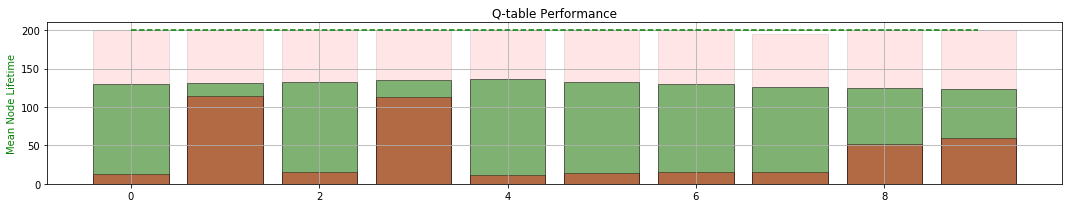

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 164.518	LOSS : 125.002	LOSS : 138.919	LOSS : 135.005	LOSS : 137.167	LOSS : 149.087	LOSS : 144.118	LOSS : 149.068	LOSS : 152.952	LOSS : 155.959	LOSS : 142.164	LOSS : 148.500	LOSS : 148.406	LOSS : 158.466	LOSS : 156.993	LOSS : 145.593	LOSS : 136.302	LOSS : 142.225	LOSS : 135.967	LOSS : 126.602	
Validating... MEAN TIME:  121.76
LOSS : 128.514	LOSS : 113.310	LOSS : 121.685	LOSS : 107.279	LOSS : 115.405	LOSS : 103.340	LOSS : 118.426	LOSS : 98.525	LOSS : 104.086	LOSS : 100.224	LOSS : 98.717	LOSS : 104.810	LOSS : 100.450	LOSS : 104.805	LOSS : 100.196	LOSS : 103.702	LOSS : 99.146	LOSS : 90.702	LOSS : 105.915	LOSS : 89.056	
Validating... MEAN TIME:  56.83
LOSS : 90.320	LOSS : 91.794	LOSS : 77.172	LOSS : 83.749	LOSS : 86.465	LOSS : 83.885	LOSS : 93.620	LOSS : 87.933	LOSS : 92.864	LOSS : 91.863	LOSS : 89.493	LOSS : 89.946	LOSS : 89.079	LOSS : 84.918	LOSS : 83.310	LOSS : 86.725	LOSS : 84.623	LOSS : 87.687	LOS

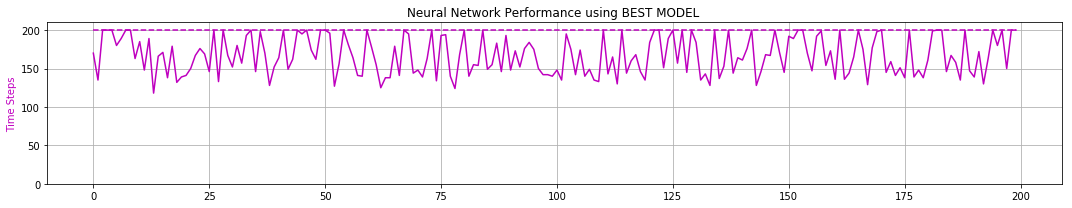

peak memory: 73680.88 MiB, increment: 65171.56 MiB
0 -max- [ 2.400  2.678  0.204  1.624  0.274]
0 -min- [-1.760 -2.348 -0.206 -1.978  0.225]

1 -max- [ 2.399  2.677  0.209  1.721  0.325]
1 -min- [-2.385 -3.081 -0.209 -1.948  0.275]

2 -max- [ 2.399  2.677  0.204  2.086  0.375]
2 -min- [-2.269 -2.772 -0.209 -1.953  0.325]

3 -max- [ 2.400  2.681  0.206  1.615  0.425]
3 -min- [-2.380 -2.973 -0.209 -1.950  0.375]

4 -max- [ 2.400  2.677  0.206  1.902  0.475]
4 -min- [-2.107 -2.578 -0.209 -1.959  0.425]

5 -max- [ 2.400  2.678  0.209  1.628  0.525]
5 -min- [-2.386 -2.875 -0.209 -1.934  0.476]

6 -max- [ 2.400  2.668  0.209  1.905  0.575]
6 -min- [-2.395 -2.959 -0.209 -1.929  0.526]

7 -max- [ 2.399  2.751  0.207  1.421  0.625]
7 -min- [-2.396 -3.099 -0.209 -1.779  0.575]

8 -max- [ 2.399  3.417  0.208  1.609  0.675]
8 -min- [-2.397 -2.964 -0.209 -2.511  0.626]

9 -max- [ 2.398  2.835  0.209  1.619  0.725]
9 -min- [-2.399 -2.954 -0.209 -1.853  0.675]

Quantization TIME:  0.59 minutes


ITER

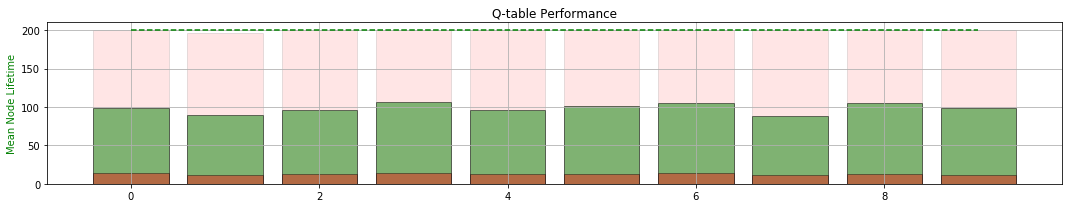

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 96.141	LOSS : 95.215	LOSS : 85.869	LOSS : 90.939	LOSS : 103.375	LOSS : 94.377	LOSS : 93.943	LOSS : 85.388	LOSS : 97.111	LOSS : 82.324	LOSS : 94.177	LOSS : 102.715	LOSS : 83.316	LOSS : 93.821	LOSS : 93.794	LOSS : 97.127	LOSS : 100.177	LOSS : 89.596	LOSS : 103.884	LOSS : 100.158	
Validating... MEAN TIME:  144.91
LOSS : 97.815	LOSS : 96.219	LOSS : 100.716	LOSS : 96.512	LOSS : 110.356	LOSS : 106.916	LOSS : 128.193	LOSS : 107.097	LOSS : 123.280	LOSS : 123.090	LOSS : 119.960	LOSS : 144.618	LOSS : 112.240	LOSS : 142.344	LOSS : 111.053	LOSS : 111.336	LOSS : 113.818	LOSS : 101.533	LOSS : 107.733	LOSS : 119.810	
Validating... MEAN TIME:  126.235
LOSS : 118.783	LOSS : 109.820	LOSS : 97.092	LOSS : 139.841	LOSS : 139.946	LOSS : 121.280	LOSS : 124.238	LOSS : 108.888	LOSS : 115.827	LOSS : 115.961	LOSS : 111.295	LOSS : 118.473	LOSS : 110.182	LOSS : 109.452	LOSS : 116.611	LOSS : 103.672	LOSS : 107.549	LOSS : 128.9

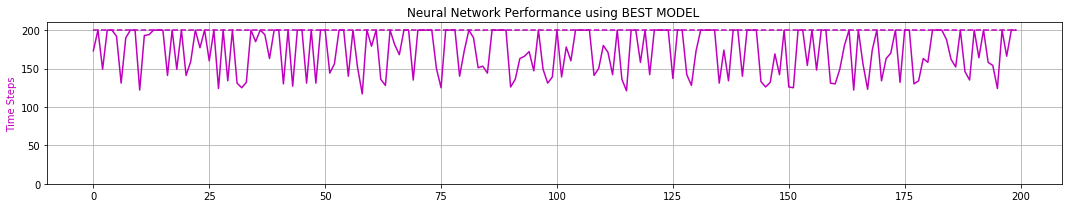

peak memory: 73845.72 MiB, increment: 65335.05 MiB
0 -max- [ 2.376  2.055  0.168  1.553  0.274]
0 -min- [-2.281 -2.779 -0.209 -1.894  0.226]

1 -max- [ 2.389  1.839  0.175  1.401  0.325]
1 -min- [-2.332 -2.760 -0.209 -1.948  0.276]

2 -max- [ 2.382  2.023  0.186  1.535  0.375]
2 -min- [-2.180 -2.580 -0.209 -2.037  0.327]

3 -max- [ 2.399  2.167  0.201  1.564  0.424]
3 -min- [-2.387 -2.952 -0.209 -1.931  0.376]

4 -max- [ 2.397  1.868  0.177  1.732  0.475]
4 -min- [-2.400 -2.961 -0.209 -2.122  0.425]

5 -max- [ 2.399  1.970  0.207  1.623  0.525]
5 -min- [-2.396 -2.965 -0.209 -2.233  0.475]

6 -max- [ 2.400  1.832  0.208  1.621  0.574]
6 -min- [-2.395 -2.960 -0.209 -2.178  0.525]

7 -max- [ 2.398  2.029  0.208  1.605  0.625]
7 -min- [-2.384 -2.970 -0.209 -2.225  0.577]

8 -max- [ 2.394  1.888  0.209  1.612  0.673]
8 -min- [-2.400 -2.944 -0.209 -2.369  0.626]

9 -max- [ 2.393  1.888  0.205  1.568  0.725]
9 -min- [-2.398 -2.945 -0.209 -2.147  0.676]

Quantization TIME:  0.59 minutes


ITER

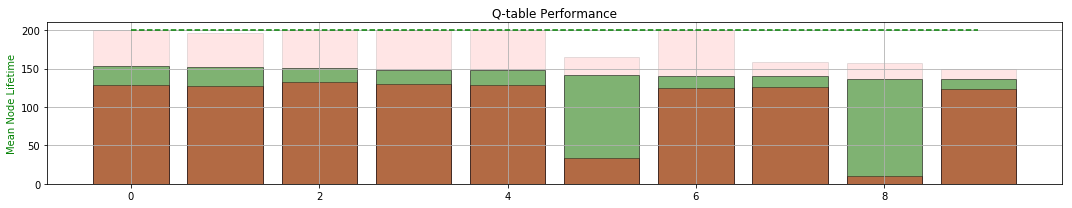

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 93.479	LOSS : 98.647	LOSS : 99.012	LOSS : 82.653	LOSS : 84.766	LOSS : 84.908	LOSS : 82.068	LOSS : 78.650	LOSS : 86.499	LOSS : 91.562	LOSS : 77.676	LOSS : 72.895	LOSS : 92.775	LOSS : 79.937	LOSS : 96.071	LOSS : 80.513	LOSS : 75.628	LOSS : 82.316	LOSS : 93.130	LOSS : 80.529	
Validating... MEAN TIME:  184.485
LOSS : 73.639	LOSS : 88.583	LOSS : 77.495	LOSS : 89.116	LOSS : 89.029	LOSS : 82.840	LOSS : 87.751	LOSS : 78.169	LOSS : 87.302	LOSS : 85.506	LOSS : 78.979	LOSS : 84.661	LOSS : 79.048	LOSS : 93.463	LOSS : 78.563	LOSS : 75.762	LOSS : 72.661	LOSS : 73.460	LOSS : 89.308	LOSS : 76.306	
Validating... MEAN TIME:  163.645
LOSS : 67.922	LOSS : 78.970	LOSS : 73.685	LOSS : 82.340	LOSS : 69.928	LOSS : 74.887	LOSS : 80.877	LOSS : 72.041	LOSS : 67.434	LOSS : 72.339	LOSS : 73.749	LOSS : 82.384	LOSS : 75.764	LOSS : 90.896	LOSS : 72.866	LOSS : 84.341	LOSS : 75.006	LOSS : 74.177	LOSS : 84.460	LOSS : 75.640	
Valida

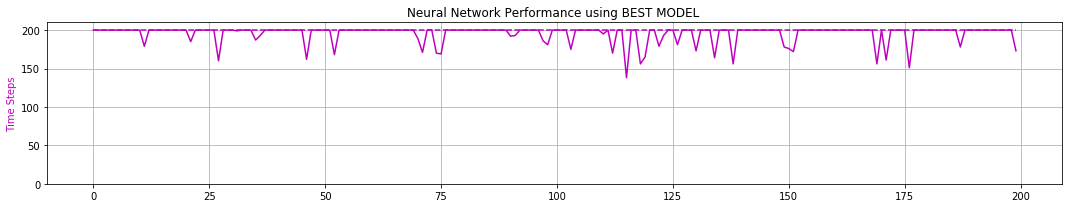

peak memory: 73950.50 MiB, increment: 65408.49 MiB
0 -max- [ 2.381  2.032  0.209  1.559  0.274]
0 -min- [-0.622 -1.306 -0.125 -1.376  0.225]

1 -max- [ 2.393  1.997  0.209  1.683  0.325]
1 -min- [-2.240 -2.693 -0.209 -1.400  0.275]

2 -max- [ 2.394  2.062  0.209  1.697  0.374]
2 -min- [-0.620 -2.199 -0.181 -1.278  0.325]

3 -max- [ 2.398  1.985  0.209  1.538  0.425]
3 -min- [-1.356 -1.457 -0.160 -1.194  0.375]

4 -max- [ 2.399  2.055  0.209  1.489  0.475]
4 -min- [-1.257 -1.836 -0.149 -1.316  0.425]

5 -max- [ 2.399  1.986  0.209  1.486  0.525]
5 -min- [-0.155 -1.013 -0.080 -1.213  0.475]

6 -max- [ 2.400  2.021  0.209  1.493  0.575]
6 -min- [-0.175 -1.021 -0.047 -1.224  0.525]

7 -max- [ 2.400  1.979  0.209  1.751  0.624]
7 -min- [-0.189 -1.204 -0.049 -1.190  0.575]

8 -max- [ 2.400  2.181  0.209  2.374  0.675]
8 -min- [-0.196 -1.525 -0.050 -1.116  0.626]

9 -max- [ 2.400  2.148  0.209  1.716  0.724]
9 -min- [-0.193 -1.202 -0.055 -1.365  0.675]

Quantization TIME:  0.59 minutes


ITER

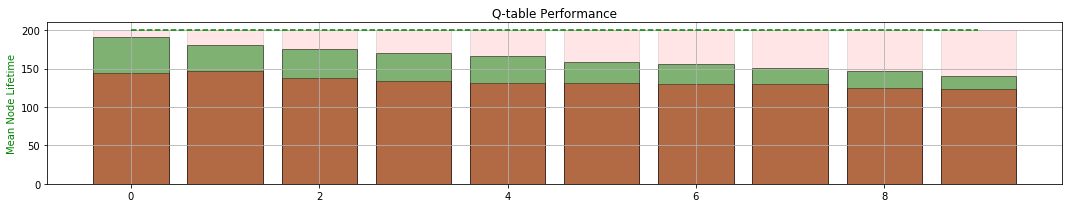

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 56.509	LOSS : 67.723	LOSS : 59.011	LOSS : 52.827	LOSS : 60.779	LOSS : 50.027	LOSS : 64.053	LOSS : 59.220	LOSS : 52.420	LOSS : 62.672	LOSS : 53.699	LOSS : 53.004	LOSS : 58.402	LOSS : 60.395	LOSS : 48.969	LOSS : 61.850	LOSS : 51.387	LOSS : 55.439	LOSS : 65.898	LOSS : 54.012	
Validating... MEAN TIME:  180.645
LOSS : 52.382	LOSS : 54.258	LOSS : 53.638	LOSS : 56.525	LOSS : 58.459	LOSS : 60.639	LOSS : 59.937	LOSS : 59.516	LOSS : 53.884	LOSS : 56.054	LOSS : 59.675	LOSS : 57.118	LOSS : 55.808	LOSS : 51.913	LOSS : 55.716	LOSS : 57.745	LOSS : 59.978	LOSS : 50.209	LOSS : 50.316	LOSS : 47.922	
Validating... MEAN TIME:  120.37
LOSS : 52.234	LOSS : 59.436	LOSS : 61.906	LOSS : 56.852	LOSS : 61.449	LOSS : 61.830	LOSS : 56.121	LOSS : 51.152	LOSS : 52.836	LOSS : 56.900	LOSS : 55.065	LOSS : 55.162	LOSS : 51.356	LOSS : 50.427	LOSS : 58.321	LOSS : 60.579	LOSS : 57.072	LOSS : 55.566	LOSS : 58.720	LOSS : 49.277	
Validat

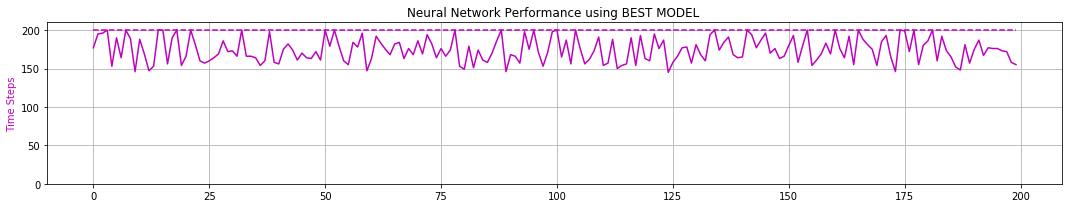

peak memory: 73648.27 MiB, increment: 65131.36 MiB
0 -max- [ 2.398  1.908  0.155  1.306  0.275]
0 -min- [-1.188 -2.553 -0.197 -1.109  0.225]

1 -max- [ 2.400  2.057  0.161  1.187  0.325]
1 -min- [-1.431 -2.555 -0.209 -1.120  0.275]

2 -max- [ 2.399  2.085  0.163  1.674  0.375]
2 -min- [-0.199 -1.847 -0.202 -1.104  0.325]

3 -max- [ 2.399  1.901  0.159  1.444  0.425]
3 -min- [-0.147 -1.853 -0.195 -1.353  0.375]

4 -max- [ 2.400  2.076  0.164  1.195  0.475]
4 -min- [-0.122 -0.818 -0.094 -1.199  0.426]

5 -max- [ 2.399  2.180  0.166  1.422  0.525]
5 -min- [-0.700 -1.271 -0.100 -1.111  0.476]

6 -max- [ 2.400  2.064  0.146  1.310  0.575]
6 -min- [-0.136 -0.825 -0.051 -1.011  0.525]

7 -max- [ 2.400  2.186  0.190  1.394  0.624]
7 -min- [-0.152 -0.995 -0.070 -1.148  0.575]

8 -max- [ 2.400  2.214  0.149  1.420  0.675]
8 -min- [-0.150 -1.007 -0.081 -1.004  0.626]

9 -max- [ 2.400  2.220  0.177  1.455  0.725]
9 -min- [-0.149 -1.011 -0.056 -1.107  0.675]

Quantization TIME:  0.59 minutes


ITER

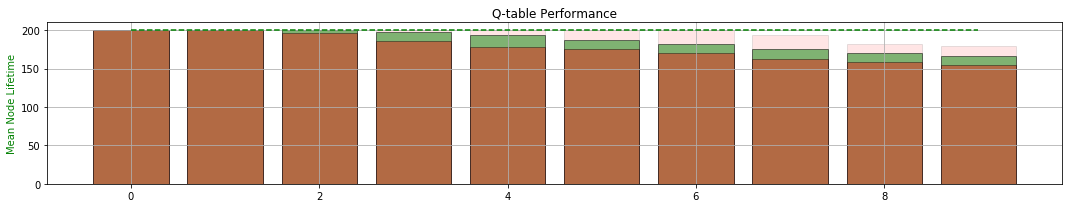

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 58.833	LOSS : 56.424	LOSS : 54.310	LOSS : 54.463	LOSS : 50.367	LOSS : 42.803	LOSS : 60.778	LOSS : 48.688	LOSS : 47.249	LOSS : 51.619	LOSS : 46.613	LOSS : 41.761	LOSS : 50.722	LOSS : 47.810	LOSS : 61.774	LOSS : 44.446	LOSS : 47.421	LOSS : 49.431	LOSS : 49.282	LOSS : 56.553	
Validating... MEAN TIME:  9.33
LOSS : 51.059	LOSS : 50.579	LOSS : 48.600	LOSS : 59.025	LOSS : 45.486	LOSS : 45.235	LOSS : 47.451	LOSS : 48.145	LOSS : 51.224	LOSS : 51.222	LOSS : 53.176	LOSS : 51.819	LOSS : 42.079	LOSS : 48.099	LOSS : 48.589	LOSS : 50.145	LOSS : 54.774	LOSS : 50.613	LOSS : 51.493	LOSS : 48.272	
Validating... MEAN TIME:  11.075
LOSS : 53.997	LOSS : 53.944	LOSS : 44.439	LOSS : 53.152	LOSS : 55.177	LOSS : 45.866	LOSS : 49.504	LOSS : 59.990	LOSS : 52.395	LOSS : 44.855	LOSS : 46.766	LOSS : 48.702	LOSS : 42.703	LOSS : 47.281	LOSS : 55.753	LOSS : 54.258	LOSS : 50.540	LOSS : 40.215	LOSS : 48.825	LOSS : 43.159	
Validating

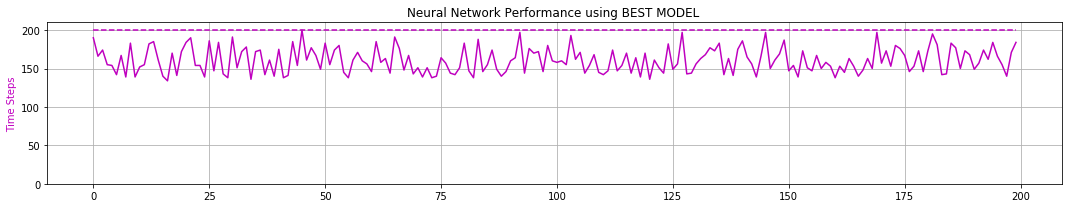

peak memory: 74170.12 MiB, increment: 65613.97 MiB
0 -max- [ 1.952  1.360  0.101  1.383  0.275]
0 -min- [-0.107 -0.989 -0.049 -1.293  0.225]

1 -max- [ 2.305  1.894  0.110  1.171  0.325]
1 -min- [-0.132 -0.815 -0.050 -1.089  0.275]

2 -max- [ 2.395  2.091  0.135  1.166  0.375]
2 -min- [-0.111 -0.826 -0.049 -1.126  0.326]

3 -max- [ 2.399  1.905  0.136  1.195  0.424]
3 -min- [-0.123 -0.821 -0.050 -1.034  0.376]

4 -max- [ 2.400  1.907  0.119  1.171  0.474]
4 -min- [-0.119 -0.826 -0.050 -0.926  0.425]

5 -max- [ 2.400  1.907  0.122  1.183  0.525]
5 -min- [-0.107 -0.825 -0.049 -0.942  0.475]

6 -max- [ 2.400  1.906  0.113  1.394  0.575]
6 -min- [-0.152 -0.995 -0.050 -1.053  0.525]

7 -max- [ 2.400  2.079  0.098  1.420  0.625]
7 -min- [-0.150 -0.984 -0.062 -1.176  0.575]

8 -max- [ 2.400  2.098  0.123  1.453  0.675]
8 -min- [-0.134 -1.016 -0.085 -1.252  0.626]

9 -max- [ 2.400  1.911  0.110  1.453  0.724]
9 -min- [-0.129 -1.013 -0.051 -1.142  0.675]

Quantization TIME:  0.59 minutes


ITER

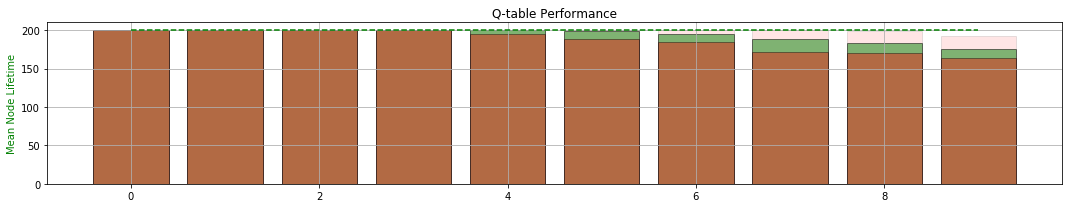

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)

            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  2516.0
Total Serial Timesteps   :  1741927.0
Speed-up                 :  692.34


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9086 SUCCESS 164  14    2516    1741927     692.34
